# Advanced Machine Learning - programming assignment 3

*Due: Friday January 12*

*Grading: 10 points total*

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Structural causal models ##
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [1]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

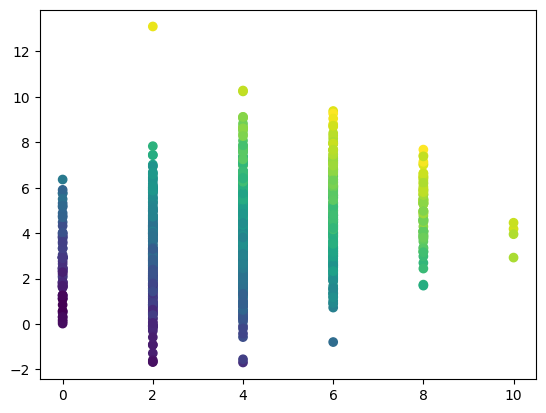

In [2]:
#plt.scatter(z, y, c=x)
plt.scatter(x, y, c=z)
plt.show()

**Task 1 (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

In [ ]:
#pip install scikit-learn

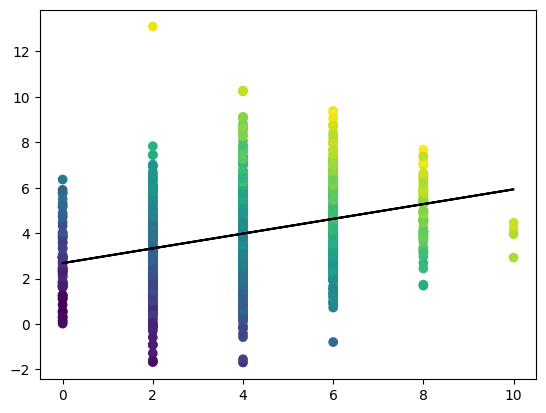

In [3]:
# Your code here
from sklearn.linear_model import LinearRegression

X = np.array(x).reshape(-1,1)
Y = np.array(y)

LR = LinearRegression()
LR.fit(X,Y)


y_pred = LR.predict(X)
plt.scatter(X, Y, c =z)
plt.plot(X, y_pred, color ='k')
 
plt.show()

Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question 2 (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

***Ans*** </br>
Z direct causes X  -- The genetic information influence the treatment strategy </br>
Both Z and X direct cause Y -- The genetic information and treatment strategy influence the outcome of treatement. Same treatement might lead different result because of the genetic difference </br>

## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task 3 (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [4]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.
    # Your code here
    z = f_Z(num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z) 

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [5]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task 4 (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

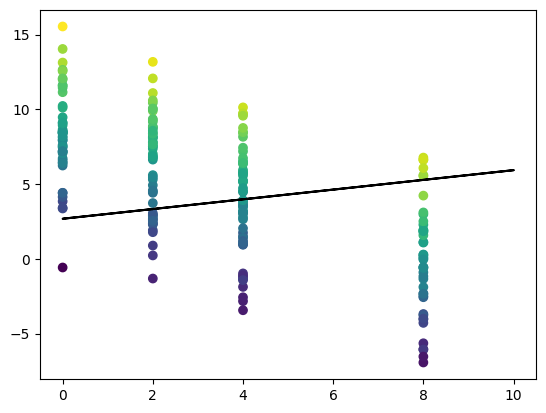

In [6]:
# Your code here
X_exp = x_exp.reshape(-1,1)
Y_exp = y_exp.reshape(-1,1)
y_pred_e = LR.predict(X_exp) #predict result for experimental data

#plt.plot(X_exp, y_pred_e, color ='r') #fitted curve for experimental data
plt.plot(X, y_pred, color ='k') #fitted curve for observstional data
plt.scatter(x_exp, y_exp, c=z_exp)
plt.show()

**Task 5 (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [9]:
# Your code here
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_exp,y_pred_e,squared=False) #get root by set squared=False
print("RMSE of linear regression model:", rmse)


RMSE of linear regression model: 5.128535578283063


You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question 6 (1 point):** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution? And what conditional distribution (which may or may not appear in either product decomposition) needs to stay the same between the two distributions, in order for your fitted curve to also give good predictions on the experimental data?

***Ans*** </br>
Product decompositions is the joint distribution of variables as a product of conditional distributions </br>
**Original SCM:**
$P(X, Y, Z) = P(Z) \cdot P(X | Z) \cdot P(Y | X, Z)$ </br>
**Modified SCM:**
$ P(X_{\text{int}}, Y_{\text{int}}, Z_{\text{int}}) = P(Z_{\text{int}}) \cdot P(X_{\text{int}}) \cdot P(Y_{\text{int}} | X_{\text{int}}, Z_{\text{int}})$ </br>

$P(Z)$: The distribution of genetic information $Z$ is assumed to be the same in both scenarios.
$P(Y | X, Z)$: The conditional distribution of $Y$ given $X$ and $Z$ is assumed to be the same in both cases, as it represents the inherent relationship between the variables. </br>
$P(Y | X, Z)$ needs to stay the same for good predictions. The model fitted to observational data should capture the causal relationships between given three variables. The conditional distribution $P(Y | X, Z)$ represents the causal effect of $X$ on $Y$ while controlling for $Z$. When making predictions on experimental data , the model's ability to generalize relies on the assumption that the causal relationship remains the same.


**Question 7 (1.5 points):** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

In [ ]:
#pip install seaborn

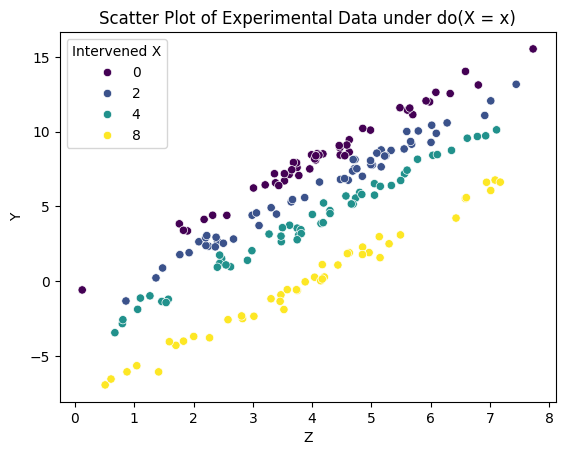

In [12]:
import seaborn as sns

sns.scatterplot(x=z_exp, y=y_exp, hue=x_exp, palette="viridis")
plt.xlabel("Z")
plt.ylabel("Y")
plt.title("Scatter Plot of Experimental Data under do(X = x)")
plt.legend(title="Intervened X")
plt.show()

X and Y are conditionally independent given Z, it means that when you condition on or fix the values of Z, any direct influence between X and Y is "blocked." 
In the scatter plot  X and Y are conditionally independent given Z,weo see no clear relationship between X and Y within each level of Z. This implies that, when you look at a specific level of Z, knowing the value of X provides little to no information about the value of Y and vice versa.

**Task 8 (2 points):** Now, we will use the method of inverse probability weighing (section 3.6 in the book, covered in lecture 12) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract an estimate of $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [11]:
# Create logistic regression object (using scikit-learn)
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

# Your code here
Z = z.reshape(-1, 1)
reg_logistic.fit(Z, x)

# gain the Predict probabilities for each data point
prob= reg_logistic.predict_proba(Z)[:, 1]
ipw = 1 / prob # Compute inverse probability weights
#print(ipw)

**Task 9 (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weigh each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

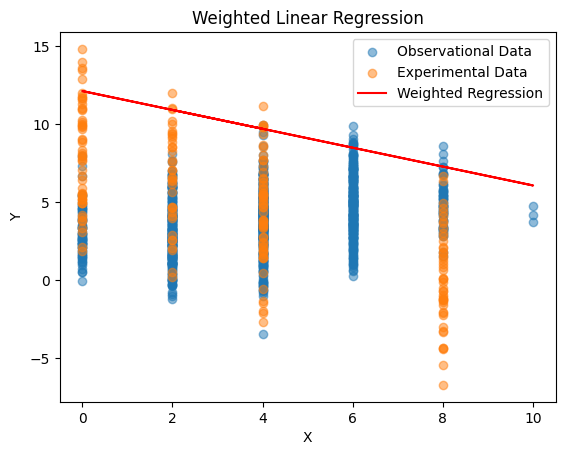

In [12]:
# Your code here
w_LRmodel = LinearRegression()
w_LRmodel.fit(X, Y, sample_weight=ipw)

y_wpred = w_LRmodel.predict(X) #prediction based on weighted model

# Plot data and regression curve
plt.scatter(x, y, label='Observational Data',alpha = 0.5)
plt.scatter(x_exp, y_exp, label='Experimental Data', alpha = 0.5 )
plt.plot(x, y_wpred, label='Weighted Regression',color = 'r')

plt.title('Weighted Linear Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

**Task 10 (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [13]:
# Your code here
y_wpred_e = w_LRmodel.predict(X_exp) #predict on experimental data

rmse_we= mean_squared_error(y_exp, y_wpred_e,squared=False)
print("RMSE of weighted linear regression model:", rmse_we)

RMSE of weighted linear regression model: 6.202987858698717


You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).